In [8]:
!git clone https://github.com/AdrianReimer/Track # my training data
!ls track

!pip install numpy --upgrade
!pip install pandas --upgrade
!pip install albumentations
!pip install --upgrade scikit-image
!pip install six numpy scipy matplotlib scikit-image opencv-python imageio Shapely
!pip install imgaug
!pip install pillow==4.1.1


fatal: destination path 'Track' already exists and is not an empty directory.
ls: cannot access 'track': No such file or directory
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.17.4)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)
  Using cached https://files.pythonhosted.org/packages/10/5c/0e94e689de2476c4c5e644a3bd223a1c1b9e2bdb7c510191750be74fa786/Pillow-6.2.1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1


Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.16.2)
  Using cached https://files.pythonhosted.org/packages/36/e5/88b3d60924a3f8476fa74ec086f5fbaba56dd6cee0d82845f883b6b6dd18/Pillow-4.1.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
  Found existing installation: Pillow 6.2.1
    Uninstalling Pillow-6.2.1:
      Successfully uninstalled Pillow-6.2.1


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [10]:
# import training data csv from track
datadir = 'Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  ...     speed
0  /Users/adrianreimer/Desktop/Data/IMG/center_2019_03_30_16_57_19_074.jpg  ...  0.590511
1  /Users/adrianreimer/Desktop/Data/IMG/center_2019_03_30_16_57_19_176.jpg  ...  0.584215
2  /Users/adrianreimer/Desktop/Data/IMG/center_2019_03_30_16_57_19_277.jpg  ...  0.577985
3  /Users/adrianreimer/Desktop/Data/IMG/center_2019_03_30_16_57_19_378.jpg  ...  0.571822
4  /Users/adrianreimer/Desktop/Data/IMG/center_2019_03_30_16_57_19_487.jpg  ...  0.564513

[5 rows x 7 columns]

In [0]:
# cuts nonrelevant abs path 
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [12]:
# cut on all 3 camera positions
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_03_30_16_57_19_074.jpg  ...  0.590511
1  center_2019_03_30_16_57_19_176.jpg  ...  0.584215
2  center_2019_03_30_16_57_19_277.jpg  ...  0.577985
3  center_2019_03_30_16_57_19_378.jpg  ...  0.571822
4  center_2019_03_30_16_57_19_487.jpg  ...  0.564513

[5 rows x 7 columns]

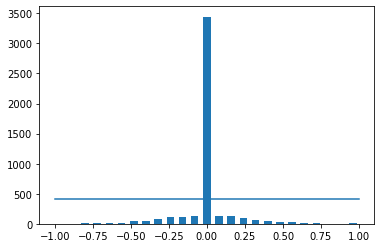

In [13]:
# create histogram of steering pos
num_bins = 25
samples_per_bin = 410 # reduce overfitting by straight-steering
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [14]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_) # shuffle data for better generalization
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

total data: 4597


removed: 3034
remaining: 1563


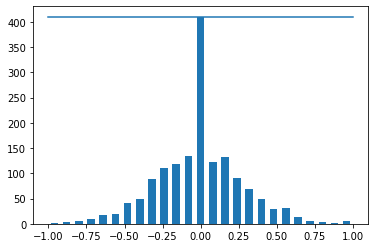

In [15]:
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [16]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

center      center_2019_03_30_16_57_20_010.jpg
left        left_2019_03_30_16_57_20_010.jpg  
right       right_2019_03_30_16_57_20_010.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       0.533916                          
Name: 9, dtype: object


Training Samples: 3751
Valid Samples: 938


Text(0.5, 1.0, 'Validation set')

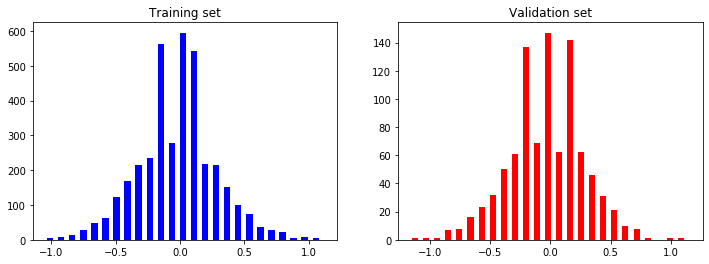

In [17]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1, 'Zoomed Image')

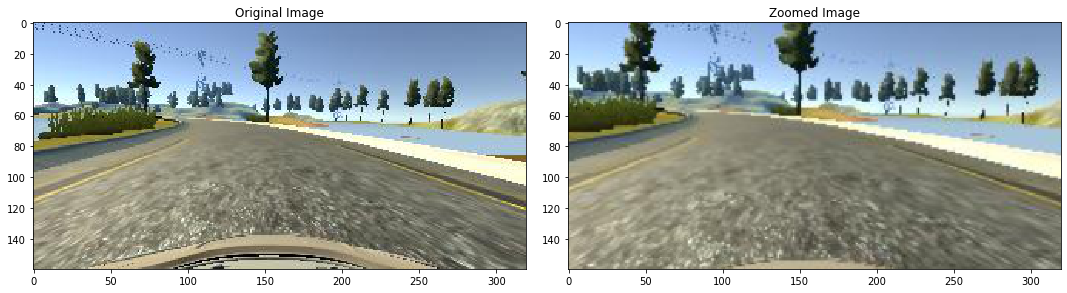

In [18]:
# zoom augmentation
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) # max 30% zoom
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
  
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image') 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1, 'Panned Image')

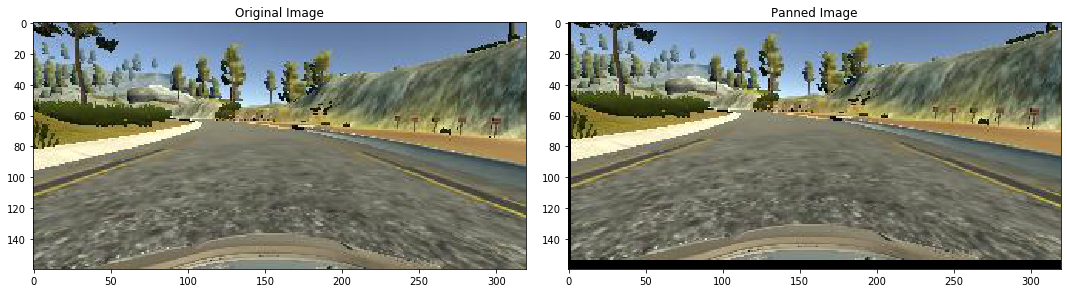

In [19]:
# pan augmentation
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)}) # +-10% hor+vert pan
  image = pan.augment_image(image)
  return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1, 'Brightness altered image ')

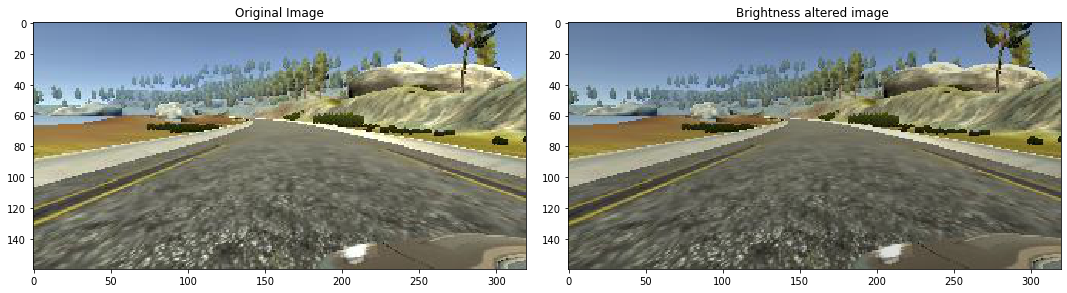

In [20]:
# brightness augmentation
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
  
  
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1, 'Flipped Image - Steering Angle:-0.418257')

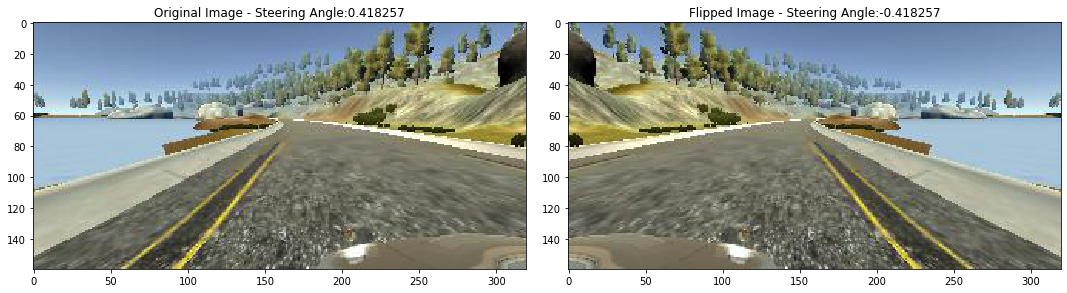

In [21]:
# flip augmentation
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
  
  
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

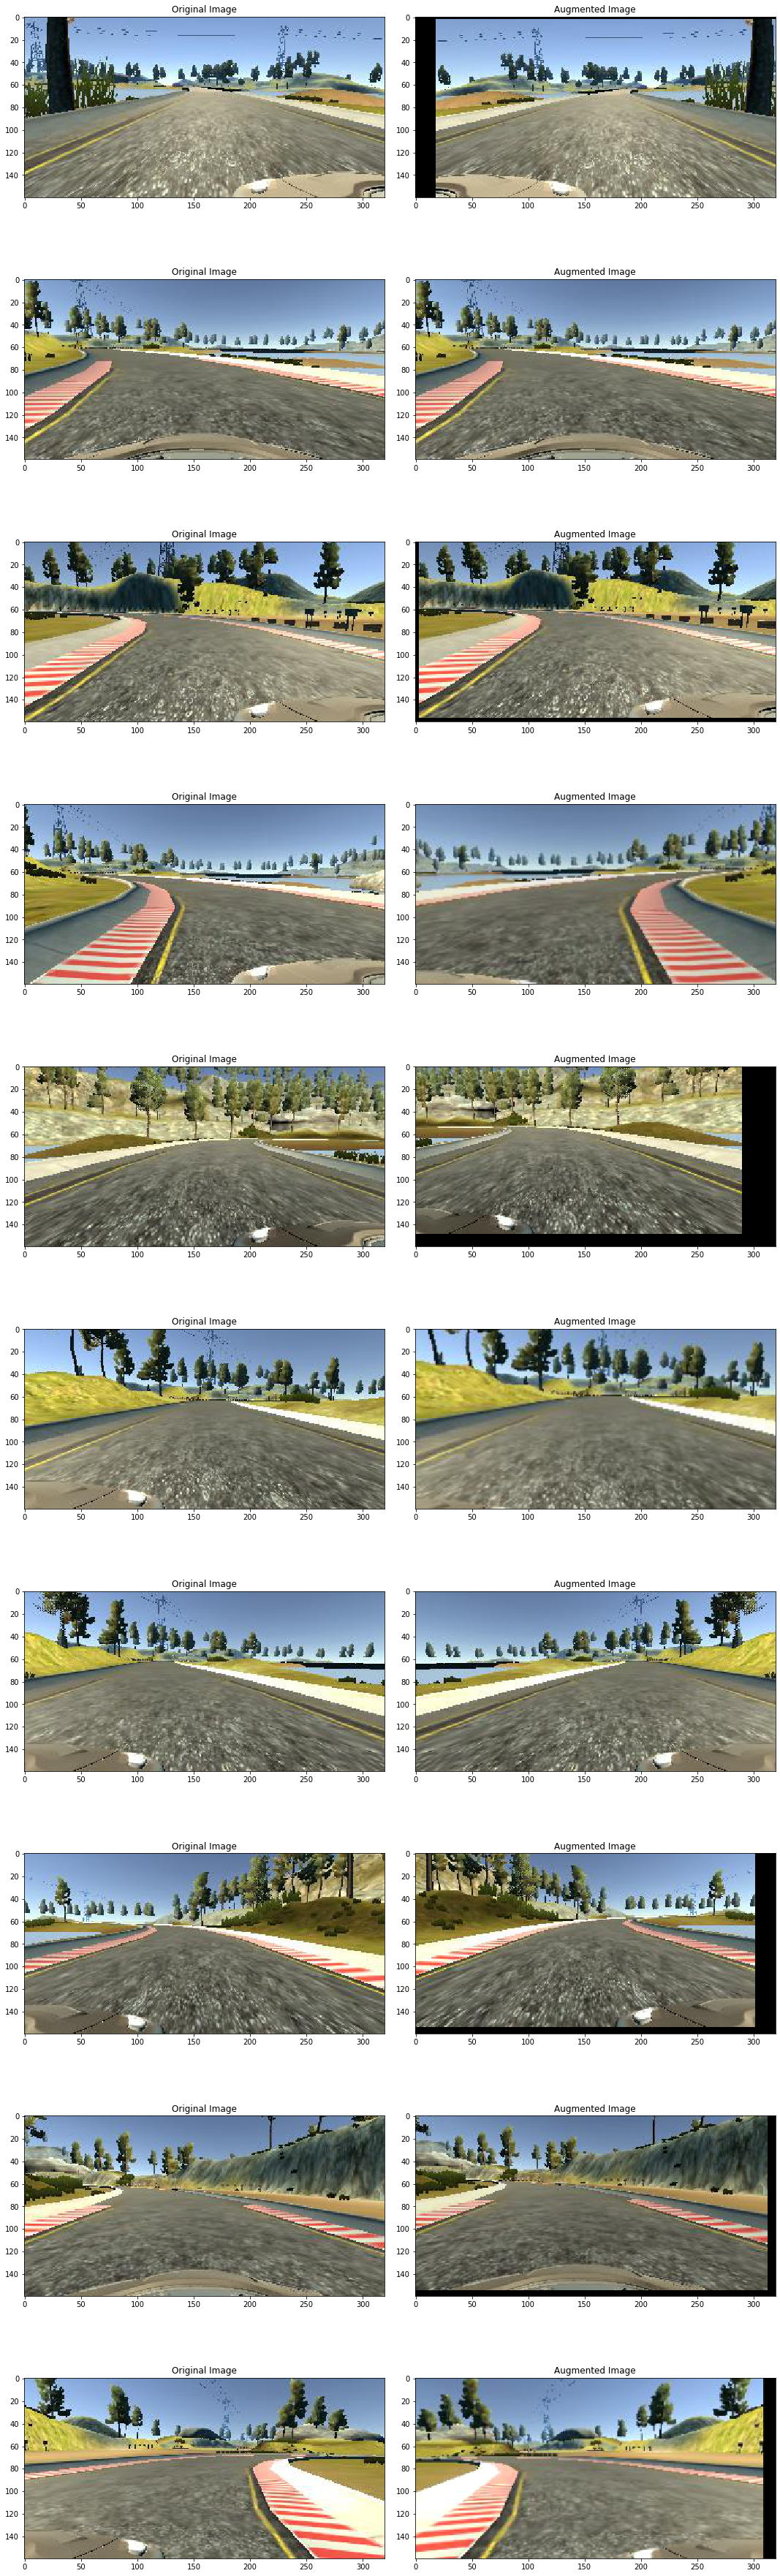

In [22]:
# augmentation chances
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)  
    return image, steering_angle
  
  
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Text(0.5, 1, 'Preprocessed Image')

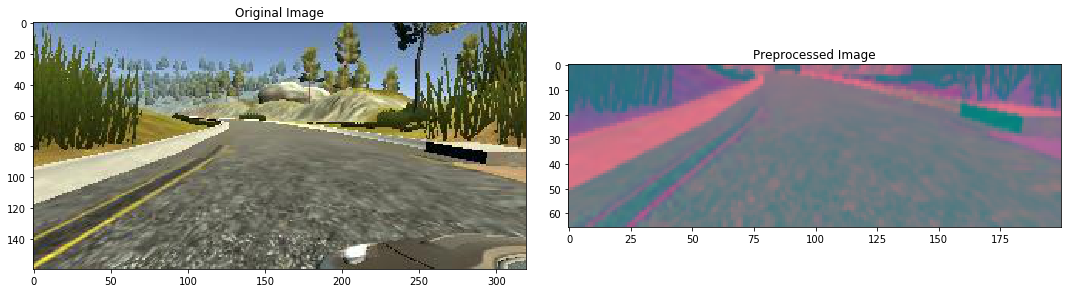

In [23]:
# delete unimportant image data
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # for nvidia model
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255 # normalization
    return img
  
  
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)     
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])   
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1, 'Validation Image')

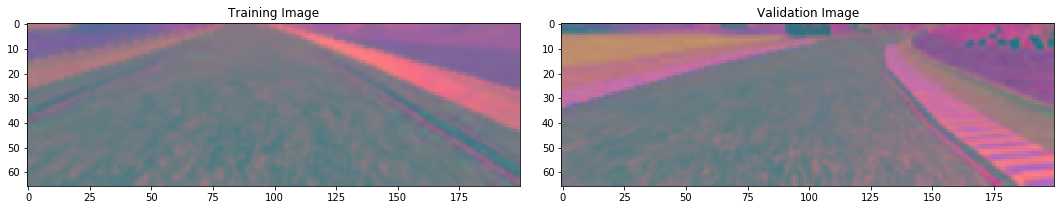

In [25]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [26]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model


model = nvidia_model()
print(model.summary())





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [27]:
# train cnn
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')




Epoch 1/10





 71/300 [======>.......................] - ETA: 2:09 - loss: 0.3614

KeyboardInterrupt: ignored

In [0]:
model.save('model.h5')

from google.colab import files
files.download('model.h5')